In [1]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from tqdm import tqdm
from tqdm.notebook import tqdm
from yaml import dump, load, safe_load

In [2]:
sys.path.append("../../sql")
import queries

sys.path.append("../source")
from ts_tools import gen_arima_params, ARIMA_optimizer

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [5]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [6]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [7]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [8]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [9]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
# df.head(5)

In [10]:
columns = df.columns.tolist()
print(columns)
forecast_on_idx = 4

['Clearsky_DNI', 'DNI', 'Clearsky_GHI', 'GHI', 'Temperature', 'Relative_Humidity', 'Precipitable_Water', 'Wind_Speed']


In [11]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

In [12]:
order_list = gen_arima_params(p_rng=(4, 5), d_rng=(0, 1), q_rng=(5, 6))
# order_list

In [13]:
results = ARIMA_optimizer(df_rsm[columns[forecast_on_idx]], order_list)
best_order = results.iloc[0]['(p, d, q)']
best_order

  0%|          | 0/8 [00:00<?, ?it/s]

(4, 1, 6)

In [14]:
def arima_model(series, p=0, d=0, q=0, s=0, num_fc=1, summary=False, forecast=False):
    """
    Takes an irradiance related series and fits an ARIMA(p, d, q) model.
    Returns a number of forecasts as specified by num_forecasts or
    a fit model is returned if forecast is not set.
    """

    start = len(series)
    end = start + num_fc

    model = ARIMA(
        series,
        order=(p, d, p),
        seasonal_order=(0, 0, 0, s),
        enforce_stationarity=True,
        trend="n",
        # freq="M",
    ).fit()

    if summary:
        print(model.summary())

    if forecast:
        forecast = model.predict(start=start, end=end)
        return forecast

    return model

In [15]:
model = arima_model(df_rsm.iloc[:252][columns[forecast_on_idx]], *best_order, s=0, summary=True)

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                  252
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -528.071
Date:                Mon, 26 Jul 2021   AIC                           1074.142
Time:                        19:44:59   BIC                           1105.871
Sample:                    01-31-1998   HQIC                          1086.910
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4228      0.094     15.058      0.000       1.238       1.608
ar.L2          0.2335      0.158      1.480      0.139      -0.076       0.543
ar.L3         -1.5018      0.133    -11.266      0.0

In [16]:
# model.plot_diagnostics()

In [17]:
forecast = arima_model(df_rsm.iloc[:252][columns[forecast_on_idx]], *results.iloc[0]['(p, d, q)'], s=0, num_fc=23, forecast=True)
# forecast = arima_model(df_rsm.iloc[:240][columns[1]], p=1, d=1, q=1, num_fc=1, forecast=True)

In [18]:
# display(df_rsm.iloc[237:240])
# df_rsm.iloc[:252][columns[1]]

In [19]:
# forecast[12:]

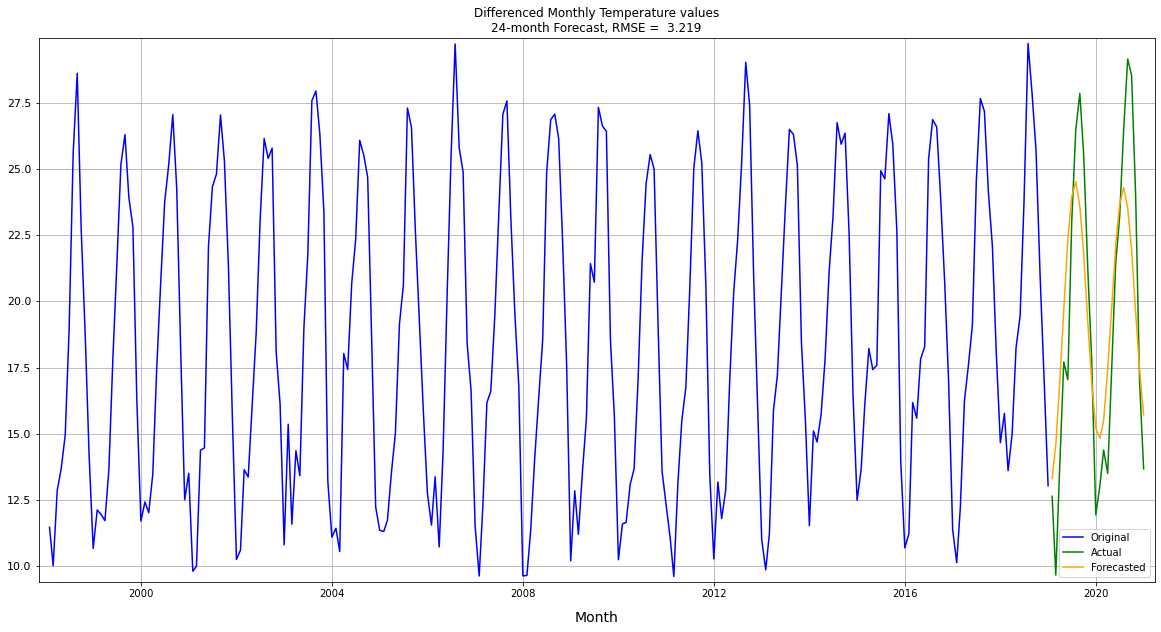

In [20]:
actual = df_rsm.iloc[252:][columns[forecast_on_idx]]

rmse = np.sqrt(np.mean((actual - forecast) ** 2))

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_rsm.iloc[:252][columns[forecast_on_idx]], label="Original", color="blue")
ax.plot(actual, label="Actual", color="green")
ax.plot(forecast, label="Forecasted", color="orange")

ax.set_xlabel("Month")

ax.set_title(
    f"Differenced Monthly {columns[forecast_on_idx]} values\n" + f"{len(forecast)}-month Forecast, RMSE = {rmse: .3f}"
)

ax.grid()
ax.legend();